In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import the libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Get the dataset and clean it
file_path = '/content/drive/My Drive/Intro to Machine Learning 4105/Level3pmR1.csv'
df = pd.read_csv(file_path)

target_col = 'Level 3pm (pieces/m3)'
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df = df.dropna(subset=[target_col])
df = df[df[target_col] != -9999]

df["Index"] = np.arange(len(df))

# Define the features and target
X = df[["Index"]]
y = df[target_col]


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ["Index"])
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
# Define and train models
models = {
    "Linear Regression": LinearRegression(),
    "SGD (Gradient Descent)": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf')
}


results = {}
y_preds = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred)
    }
    y_preds[name] = y_pred

# Display the evaluation table
results_df = pd.DataFrame(results).T
display(results_df)


,R2,MAE,MSE
Linear Regression,0.011340,0.280845,1.455882
SGD (Gradient Descent),0.011394,0.281047,1.455803
Ridge Regression,0.011335,0.280831,1.455889
Lasso Regression,-0.003041,0.288926,1.477059
Random Forest,0.069519,0.213876,1.370209
SVR,-0.008129,0.256665,1.484551


/tmp/ipython-input-858680052.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df["R2"], y=results_df.index, palette='mako')


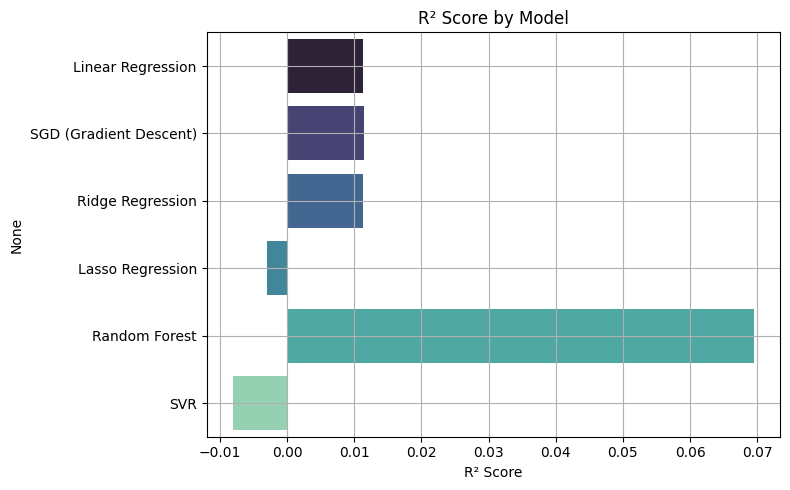

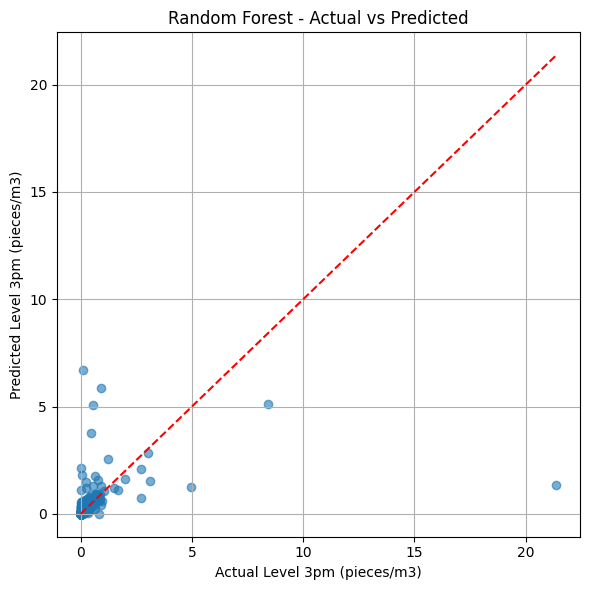

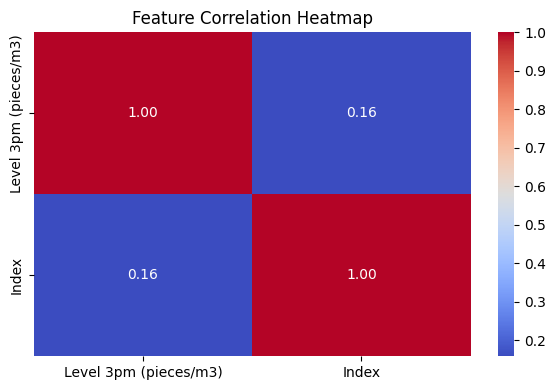

In [8]:
# Plot R^2 Scores
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df["R2"], y=results_df.index, palette='mako')
plt.title("R² Score by Model")
plt.xlabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the actual vs predicted for the best model
best_model = results_df["R2"].idxmax()
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_preds[best_model], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"{best_model} - Actual vs Predicted")
plt.xlabel("Actual Level 3pm (pieces/m3)")
plt.ylabel("Predicted Level 3pm (pieces/m3)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation for the heatmap
plt.figure(figsize=(6, 4))
correlation = df[[target_col, "Index"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [9]:
# ANN MODEL

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import the libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Get the data and clean it
file_path = '/content/drive/My Drive/Intro to Machine Learning 4105/Level3pmR1.csv'
df = pd.read_csv(file_path)

target_col = 'Level 3pm (pieces/m3)'
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df = df.dropna(subset=[target_col])
df = df[df[target_col] != -9999]

df["Index"] = np.arange(len(df))
X = df[["Index"]].values
y = df[target_col].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [11]:
# Build improved ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=10, factor=0.5, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


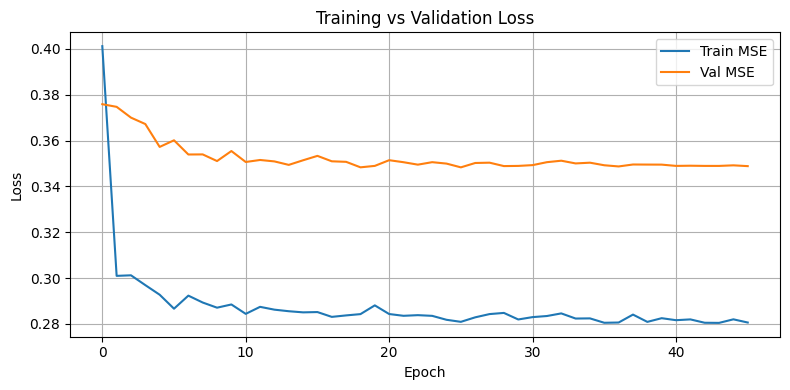

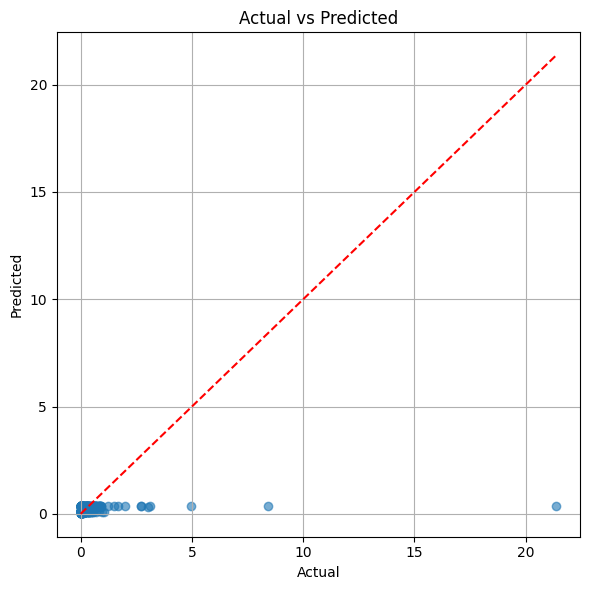

R² Score: 0.0254
MAE: 0.2790
MSE: 1.4351


In [12]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 66: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 71: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 76: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


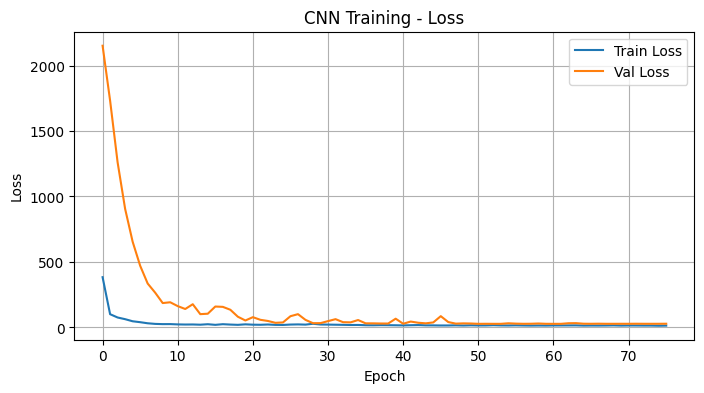

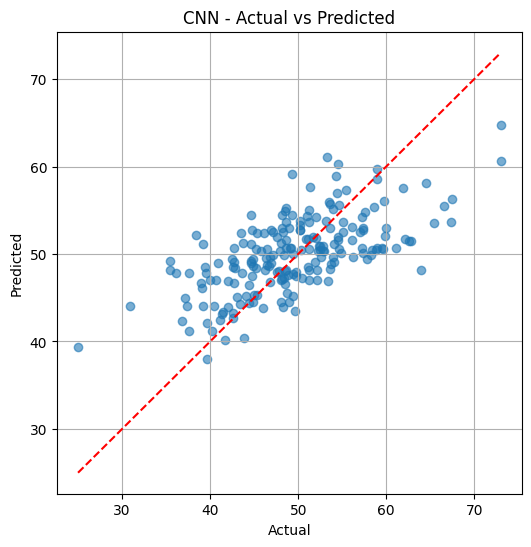

R² Score: 0.4117
MAE: 4.5613
MSE: 32.5461


In [1]:
# CNN

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Generate synthetic image data again
def generate_image_data(n_samples=1000, img_size=32):
    X = np.zeros((n_samples, img_size, img_size, 1))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        img = np.random.rand(img_size, img_size)
        target = np.mean(img[14:18, 14:18]) * 100
        X[i, :, :, 0] = img
        y[i] = target
    return X, y

X, y = generate_image_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build THE CNN model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128),
    LeakyReLU(),
    Dropout(0.4),
    Dense(1)
])

# Compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

# Train
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr],
                    verbose=0)

# Predict & Evaluate
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Plot Training History
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Training - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot Predictions
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("CNN - Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

# Print Metrics
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
